In [96]:
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import sys
print sys.path
%matplotlib inline

['', '/Users/rtindru/anaconda/lib/python2.7/site-packages/seaborn-0.7.0-py2.7.egg', '/Users/rtindru/anaconda/lib/python27.zip', '/Users/rtindru/anaconda/lib/python2.7', '/Users/rtindru/anaconda/lib/python2.7/plat-darwin', '/Users/rtindru/anaconda/lib/python2.7/plat-mac', '/Users/rtindru/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/rtindru/anaconda/lib/python2.7/lib-tk', '/Users/rtindru/anaconda/lib/python2.7/lib-old', '/Users/rtindru/anaconda/lib/python2.7/lib-dynload', '/Users/rtindru/anaconda/lib/python2.7/site-packages/Sphinx-1.3.5-py2.7.egg', '/Users/rtindru/anaconda/lib/python2.7/site-packages/setuptools-20.3-py2.7.egg', '/Users/rtindru/anaconda/lib/python2.7/site-packages', '/Users/rtindru/anaconda/lib/python2.7/site-packages/aeosa', '/Users/rtindru/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/rtindru/.ipython']


In [97]:
df_train = pd.read_csv('../Kaggle_Datasets/Facebook/train.csv')
df_test = pd.read_csv('../Kaggle_Datasets/Facebook/test.csv')

In [98]:
mini_df = df_train[(df_train.x > 7.0) & (df_train.x < 7.5) & (df_train.y > 3.0) & (df_train.y < 3.25)]

In [99]:
df_train = None
df_test = None

In [100]:
def mean_diff(df):
    unique_places = df.place_id.unique()
    means = {}
    
    for place_id in unique_places:
        df_place = df[df.place_id == place_id]
        xmean = df_place.x.mean()
        ymean = df_place.y.mean()
        means[place_id] = (xmean, ymean)

    def apply_mean_x(place_id):
        return means[place_id][0]
    
    def apply_mean_y(place_id):
        return means[place_id][1]
    
    df['xmean'] = df.place_id.apply(apply_mean_x)
    df['ymean'] = df.place_id.apply(apply_mean_y)
    df['xdist'] = np.abs(df.x - df.xmean)
    df['ydist'] = np.abs(df.y - df.ymean)
    
    return df

In [101]:
def mod_df(mini_df):
    mini_df.loc[:, 'hour'] = mini_df.time // 60 % 24 + 1
    mini_df.loc[:, 'day'] = mini_df.time // (60*24) % 7 + 1
    mini_df.loc[:, 'week'] = mini_df.time // (60*24*7) % 52 + 1
    mini_df.loc[:, 'month'] = mini_df.time // (60*24*30) % 12 + 1
    mini_df.loc[:, 'year'] = mini_df.time // (60*24*365) + 1

    mini_df.loc[:, 'hours'] = mini_df.time // 60 + 1
    mini_df.loc[:, 'days'] = mini_df.time // (60*24) + 1
    mini_df.loc[:, 'weeks'] = mini_df.time // (60*24*7) + 1
    mini_df.loc[:, 'months'] = mini_df.time // (60*24*30) + 1
    mini_df.loc[:, 'years'] = mini_df.time // (60*24*365) + 1
    
    mini_df.loc[:, 'hour_float'] = mini_df.time / 60 % 24 + 1
    mini_df.loc[:, 'day_float'] = mini_df.time / (60*24) % 7 + 1
    mini_df.loc[:, 'week_float'] = mini_df.time / (60*24*7) % 52 + 1
    mini_df.loc[:, 'month_float'] = mini_df.time / (60*24*30) % 12 + 1
    mini_df.loc[:, 'year_float'] = mini_df.time / (60*24*365) + 1

    mini_df.loc[:, 'log2_accuracy'] = np.log2(mini_df.accuracy) * 10
    mini_df.loc[:, 'log10_accuracy'] = np.log10(mini_df.accuracy) * 10
    mini_df.loc[:, 'log2_accuracy_int'] = (np.log2(mini_df.accuracy) * 10).astype(int)
    mini_df.loc[:, 'log10_accuracy_int'] = (np.log10(mini_df.accuracy) * 10).astype(int)
    
    return mini_df

In [102]:
mini_df = mod_df(mini_df)
mini_df = mean_diff(mini_df)
mini_df.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,month_float,year_float,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int,xmean,ymean,xdist,ydist
301,301,7.3815,3.2452,12,467320,4836326665,13,3,47,11,...,11.817593,1.889117,35.849625,10.791812,35,10,7.392903,3.242931,0.011403,0.002269
2339,2339,7.3378,3.0791,8,215857,6676464189,22,3,22,5,...,5.996690,1.410687,30.000000,9.030900,30,9,7.295541,3.082064,0.042259,0.002964
2984,2984,7.2308,3.0956,61,588233,8100169726,12,3,7,2,...,2.616505,2.119165,59.307373,17.853298,59,17,7.182990,3.080717,0.047810,0.014883
2993,2993,7.1892,3.2495,13,47081,7896926684,17,5,5,2,...,2.089838,1.089576,37.004397,11.139434,37,11,7.206654,3.224724,0.017454,0.024776
3336,3336,7.3740,3.0347,76,649934,6144260946,9,4,13,4,...,4.044769,2.236556,62.479275,18.808136,62,18,7.296300,3.015476,0.077700,0.019224


In [14]:
mini_df.columns

Index([u'row_id', u'x', u'y', u'accuracy', u'time', u'place_id', u'hour',
       u'day', u'week', u'month', u'year', u'hours', u'days', u'weeks',
       u'months', u'years', u'hour_float', u'day_float', u'week_float',
       u'month_float', u'year_float', u'accu_class', u'log2_accuracy',
       u'log10_accuracy', u'log2_accuracy_int', u'log10_accuracy_int'],
      dtype='object')

In [15]:
len(mini_df.place_id.unique())

1347

In [103]:
train, test = train_test_split(mini_df, random_state=88)

In [10]:
# Using float day, week and month instead of rounded ints
attributes_6 = [u'x', u'y', u'time', u'hour_float', u'day_float', u'week_float', u'month_float',
       u'year_float', u'log2_accuracy',]

In [139]:
model_6 = RandomForestClassifier(n_estimators=30, warm_start=True, random_state=3, n_jobs=-1)

In [140]:
model_6.fit(train.loc[:, attributes_6], train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [141]:
model_6.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [21]:
# How does 30 estimators compare
model_6a = RandomForestClassifier(n_estimators=30, warm_start=True, random_state=3, n_jobs=-1)
model_6a.fit(train.loc[:, attributes_6], train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [22]:
model_6a.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [31]:
# Does warm start matter?
model_6b = RandomForestClassifier(n_estimators=30, warm_start=False, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [33]:
#max_features matter?
model_6b = RandomForestClassifier(n_estimators=30, max_features=None, warm_start=False, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.54923170238576624

In [35]:
#max_features matter?
model_6b = RandomForestClassifier(n_estimators=30, max_features='log2', warm_start=False, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [36]:
# Does min sample matter?
model_6b = RandomForestClassifier(n_estimators=30, warm_start=False, random_state=3, n_jobs=-1, min_samples_split=1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [37]:
# Criterion? 
model_6b = RandomForestClassifier(n_estimators=30, warm_start=False, random_state=3, n_jobs=-1, criterion="entropy")
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.57177517185604532

In [39]:
# How about 50?
model_6b = RandomForestClassifier(n_estimators=50, warm_start=False, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.58158107561665995

In [38]:
# How about 50 with entropy
model_6b = RandomForestClassifier(n_estimators=50, warm_start=False, random_state=3, n_jobs=-1, criterion="entropy")
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.58016579053780837

In [27]:
model_6a = None; model_6 = None

In [28]:
# How about 70???
model_6b = RandomForestClassifier(n_estimators=70, warm_start=False, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.58380509502628386

In [44]:
# Go Nuts
model_6b = RandomForestClassifier(n_estimators=100, warm_start=True, random_state=3, n_jobs=-1)
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.58613020622725431

In [47]:
# Using int accuracy
attributes_7 = [u'x', u'y', u'time', u'hour_float', u'day_float', u'week_float', u'month_float',
       u'year_float', u'log2_accuracy_int',]

In [48]:
model_7 = RandomForestClassifier(n_estimators=20, warm_start=True, random_state=3, n_jobs=-1)

In [49]:
model_7.fit(train.loc[:, attributes_7], train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [50]:
model_7.score(test.loc[:, attributes_7], test.place_id)

0.5612616255560049

In [43]:
model_6b = MLPClassifier(hidden_layer_sizes=(1500, ), warm_start=False, random_state=3, )
model_6b.fit(train.loc[:, attributes_6], train.place_id)
model_6b.score(test.loc[:, attributes_6], test.place_id)

0.033461382935705622

In [57]:
train.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,hour_float,day_float,week_float,month_float,year_float,accu_class,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int
10052685,10052685,7.1326,3.0535,49,636524,2521043038,1,2,12,3,...,1.733333,2.030556,12.147222,3.734352,2.211043,1,56.147098,16.901961,56,16
25271240,25271240,7.4475,3.0244,77,288735,3176435615,13,5,29,7,...,13.250000,5.510417,29.644345,7.683681,1.549344,-1,62.667865,18.864907,62,18
6775964,6775964,7.3827,3.0245,65,303279,7757452108,15,1,31,8,...,15.650000,1.610417,31.087202,8.020347,1.577015,-2,60.223678,18.129134,60,18
9207018,9207018,7.3037,3.1887,14,227196,2542287394,19,4,23,6,...,19.600000,4.775000,23.539286,6.259167,1.432260,1,38.073549,11.461280,38,11
15776617,15776617,7.0069,3.0630,69,473591,2959543910,22,7,47,11,...,22.183333,7.882639,47.983234,11.962755,1.901048,-1,61.085245,18.388491,61,18


In [8]:
train, test = train_test_split(mini_df, random_state=88)

In [117]:
# Using float day, week and month instead of rounded ints
attributes_6 = [u'x', u'y', u'time', u'hour_float', u'day_float', u'week_float', u'month_float',
       u'year_float', u'log2_accuracy',]
scale_attrs = [ u'time', u'hour_float', u'day_float', u'week_float', u'month_float',
       u'year_float', u'log2_accuracy',]
df_norm = (train - train.mean()) / (train.max() - train.min())
df_norm.x = train.x
df_norm.y = train.y
df_norm.row_id = train.row_id
df_norm.place_id = train.place_id
df_norm.head()

test_norm = (test - train.mean()) / (train.max() - train.min())
test_norm.x = test.x
test_norm.y = test.y
test_norm.row_id = test.row_id
test_norm.place_id = test.place_id

test_norm2 = (test - test.mean()) / (test.max() - test.min())
test_norm2.x = test.x
test_norm2.y = test.y
test_norm2.row_id = test.row_id
test_norm2.place_id = test.place_id



In [122]:
model_6b = MLPClassifier(hidden_layer_sizes=(1000, ), warm_start=False, random_state=3, )
model_6b.fit(df_norm.loc[:, attributes_6], df_norm.place_id)

MLPClassifier(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=3, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [123]:
model_6b.score(test_norm.loc[:, attributes_6], test_norm.place_id)

0.43479579458147999

In [124]:
model_6b.score(tdf.plot('row', 'min_accu', kind='scatter')test_norm2.loc[:, attributes_6], test_norm2.place_id)

0.43540234532955924

In [131]:
attributes_6

[u'x',
 u'y',
 u'time',
 u'hour_float',
 u'day_float',
 u'week_float',
 u'month_float',
 u'year_float',
 u'log2_accuracy']

In [132]:
weights = {
    u'x': 120,
    u'y': 300,
    u'hour_float': 100,
    u'day_float': 60,
    u'week_float': 40,
    u'month_float': 20,
    u'year_float': 10,
    u'log2_accuracy': 140,
}

In [19]:
model_6 = RandomForestClassifier(n_estimators=30, warm_start=True, random_state=3, n_jobs=1, )
model_6.fit(train.loc[:, attributes_6], train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [20]:
model_6.score(test.loc[:, attributes_6], test.place_id)

0.57096643752527299

In [15]:
def remove_sparse(df, lt=5):
    id_counts = df.place_id.value_counts()
    dense_indices = np.where(id_counts >= lt)
    dense_places = id_counts.index[dense_indices]
    return df[df.place_id.isin(dense_places)]

In [16]:
dense_train = remove_sparse(train)
dense_train.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,years,hour_float,day_float,week_float,month_float,year_float,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int
10052685,10052685,7.1326,3.0535,49,636524,2521043038,1,2,12,3,...,2,1.733333,2.030556,12.147222,3.734352,2.211043,56.147098,16.901961,56,16
25271240,25271240,7.4475,3.0244,77,288735,3176435615,13,5,29,7,...,1,13.250000,5.510417,29.644345,7.683681,1.549344,62.667865,18.864907,62,18
6775964,6775964,7.3827,3.0245,65,303279,7757452108,15,1,31,8,...,1,15.650000,1.610417,31.087202,8.020347,1.577015,60.223678,18.129134,60,18
9207018,9207018,7.3037,3.1887,14,227196,2542287394,19,4,23,6,...,1,19.600000,4.775000,23.539286,6.259167,1.432260,38.073549,11.461280,38,11
15776617,15776617,7.0069,3.0630,69,473591,2959543910,22,7,47,11,...,1,22.183333,7.882639,47.983234,11.962755,1.901048,61.085245,18.388491,61,18


In [21]:
model_6 = RandomForestClassifier(n_estimators=30, warm_start=True, random_state=3, n_jobs=1, )
model_6.fit(dense_train.loc[:, attributes_6], dense_train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [22]:
model_6.score(test.loc[:, attributes_6], test.place_id)

0.57288718156085727

In [104]:
dense_train = remove_sparse(train, 10)
dense_train.head()
model_6 = RandomForestClassifier(n_estimators=30, warm_start=True, random_state=3, n_jobs=1, )
model_6.fit(dense_train.loc[:, attributes_6], dense_train.place_id)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=True)

In [105]:
model_6.score(test.loc[:, attributes_6], test.place_id)

0.57056207035988682

In [106]:
preds = model_6.predict(test.loc[:, attributes_6])

In [107]:
rindices = test.index[preds == test.place_id]
windices = test.index[preds != test.place_id]
right = test[test.index.isin(rindices)]
wrong = test[test.index.isin(windices)]

In [35]:
right.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,years,hour_float,day_float,week_float,month_float,year_float,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int
322146,322146,7.0124,3.0477,167,28612,2959543910,21,6,3,1,...,1,21.866667,6.869444,3.838492,1.662315,1.054437,73.837043,22.227165,73,22
20413522,20413522,7.4900,3.1085,65,317461,3317409564,12,4,32,8,...,1,12.016667,4.459028,32.494147,8.348634,1.603997,60.223678,18.129134,60,18
15875279,15875279,7.3341,3.1641,21,67350,2542287394,19,5,7,2,...,1,19.500000,5.770833,7.681548,2.559028,1.128139,43.923174,13.222193,43,13
8916124,8916124,7.1657,3.1359,52,42385,4853798284,11,2,5,1,...,1,11.416667,2.434028,5.204861,1.981134,1.080641,57.004397,17.160033,57,17
23917994,23917994,7.1625,3.1352,70,43239,4853798284,1,3,5,2,...,1,1.650000,3.027083,5.289583,2.000903,1.082266,61.292830,18.450980,61,18


In [36]:
wrong.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,years,hour_float,day_float,week_float,month_float,year_float,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int
5211419,5211419,7.4261,3.0881,2,126013,9523909729,13,4,13,3,...,1,13.216667,4.509028,13.501290,3.916968,1.239751,10.000000,3.010300,10,3
6803741,6803741,7.2250,3.2341,63,269163,8515327463,23,5,27,7,...,1,23.050000,5.918750,27.702679,7.230625,1.512106,59.772799,17.993405,59,17
20748728,20748728,7.0641,3.1282,74,757060,8409791283,18,1,24,6,...,2,18.666667,1.736111,24.105159,6.524537,2.440373,62.094534,18.692317,62,18
16763854,16763854,7.3762,3.1514,66,780472,5564204353,24,3,26,7,...,2,24.866667,3.994444,26.427778,7.066481,2.484916,60.443941,18.195439,60,18
3354639,3354639,7.4264,3.1899,34,542174,2621839135,13,6,2,1,...,2,13.233333,6.509722,2.787103,1.550324,2.031533,50.874628,15.314789,50,15


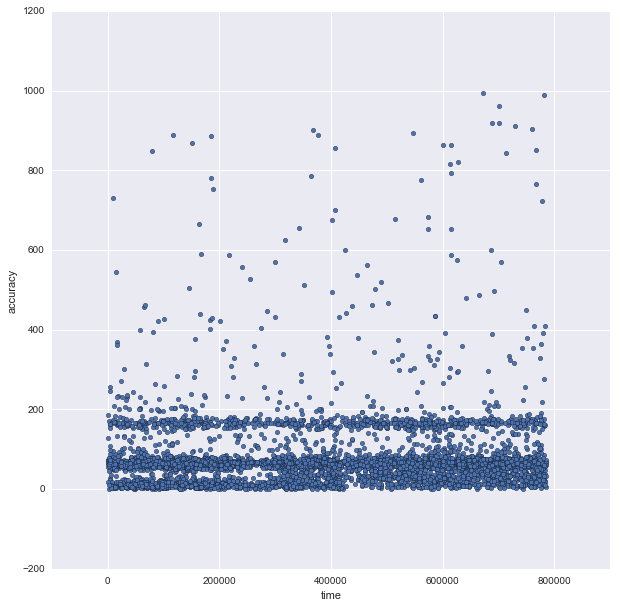

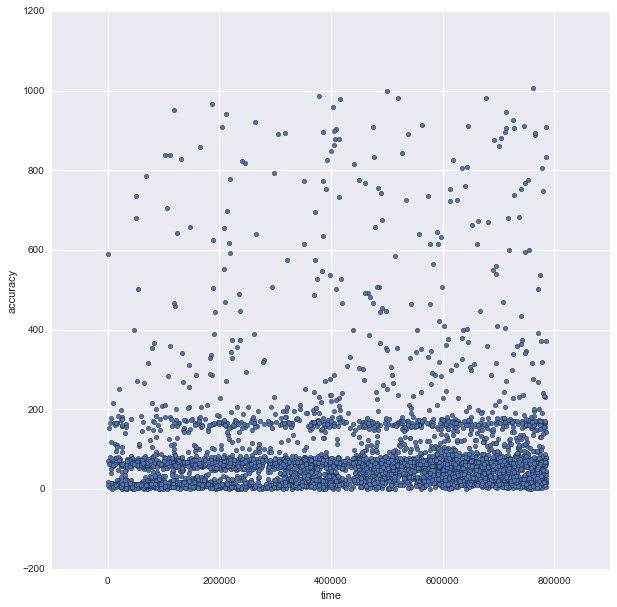

In [45]:
right.plot(x='time', y='accuracy', kind='scatter', figsize=(10, 10))
wrong.plot(x='time', y='accuracy', kind='scatter', figsize=(10, 10))

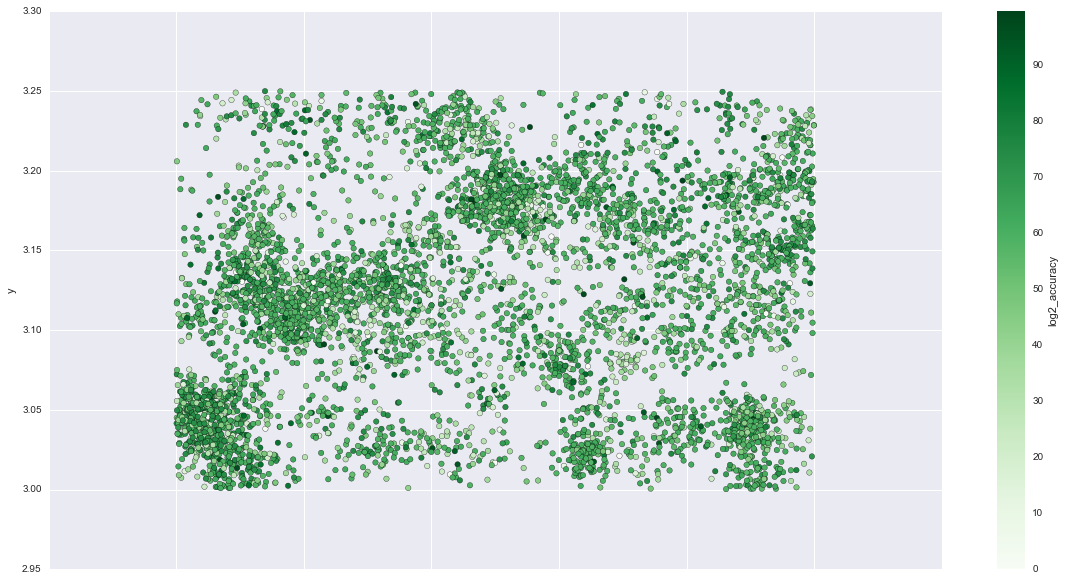

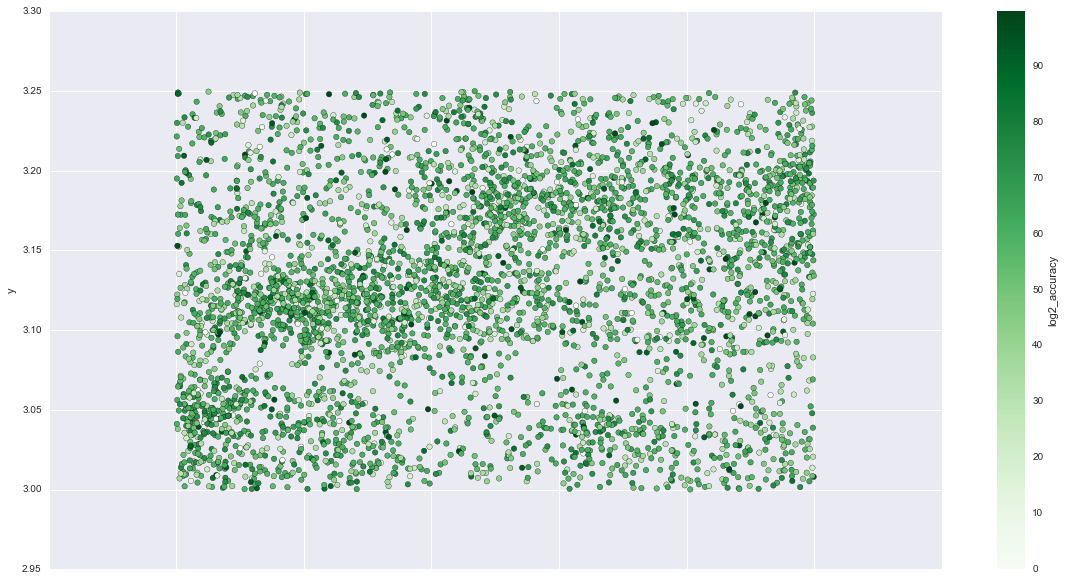

In [55]:
right.plot('x', 'y', c='log2_accuracy', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')
wrong.plot('x', 'y', c='log2_accuracy', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')

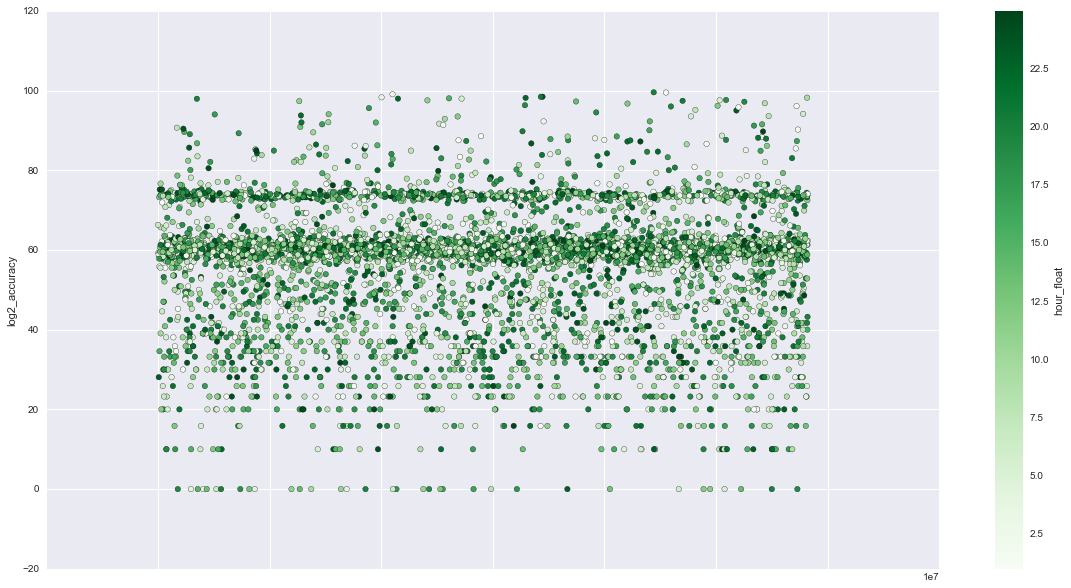

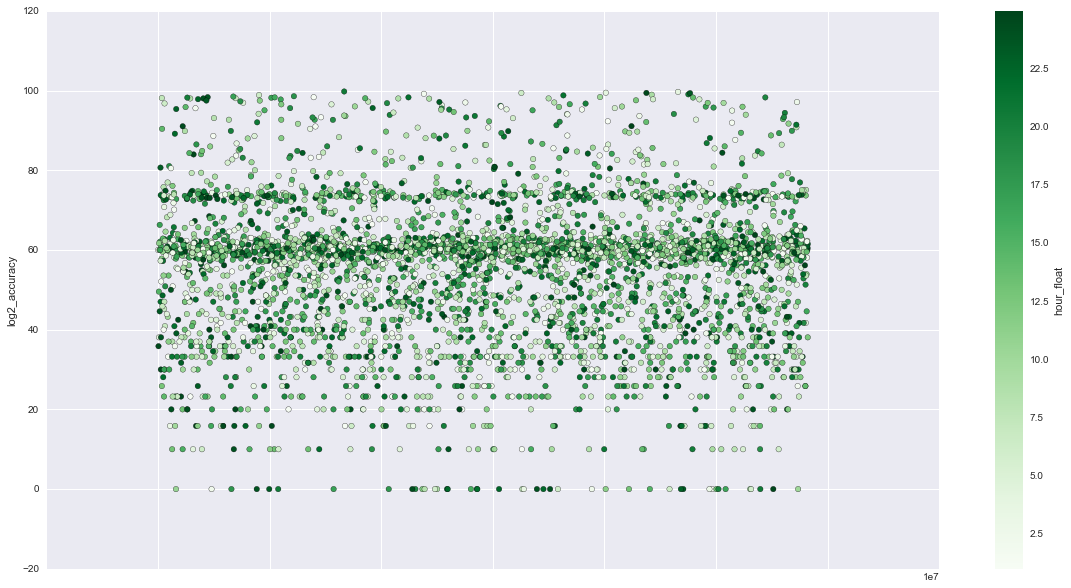

In [62]:
right.plot('row_id', 'log2_accuracy', c='hour_float', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')
wrong.plot('row_id', 'log2_accuracy', c='hour_float', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')

In [108]:
w = wrong.sample(500)

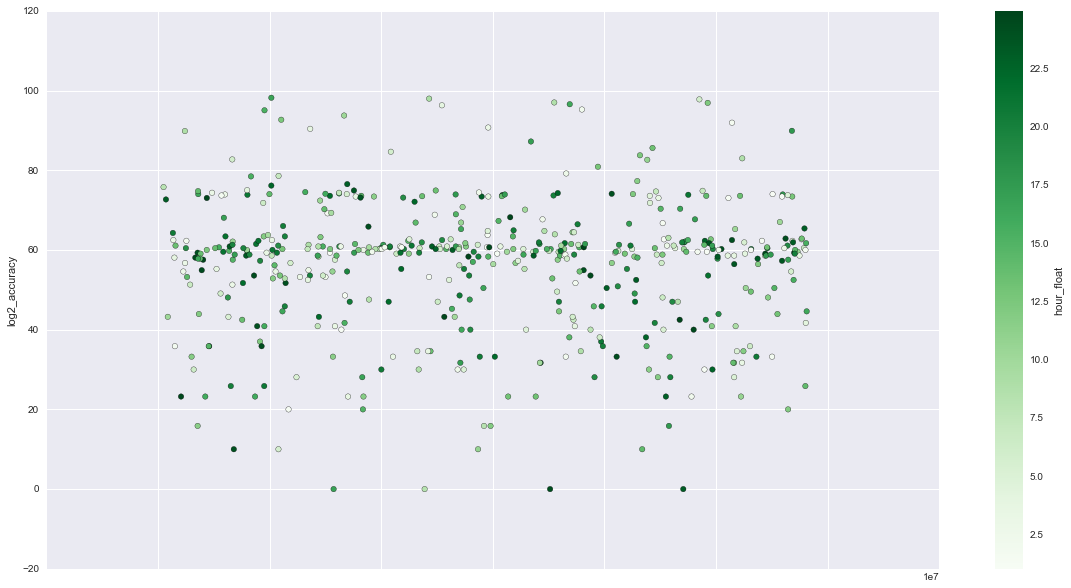

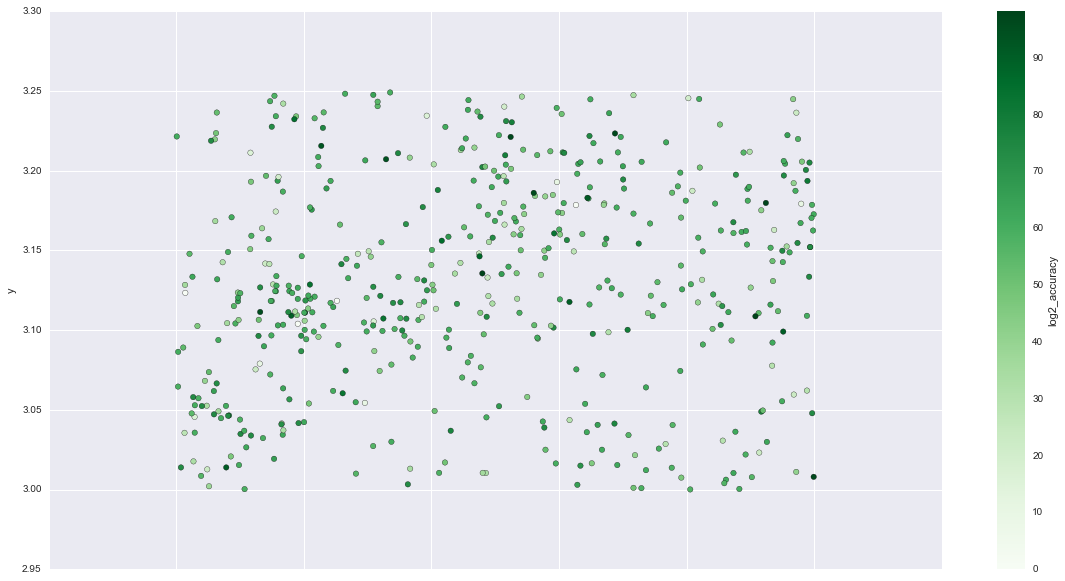

In [63]:
w.plot('row_id', 'log2_accuracy', c='hour_float', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')
w.plot('x', 'y', c='log2_accuracy', s=30, kind='scatter', figsize=(20, 10), cmap='Greens')

In [109]:
w.head()

,row_id,x,y,accuracy,time,place_id,hour,day,week,month,...,month_float,year_float,log2_accuracy,log10_accuracy,log2_accuracy_int,log10_accuracy_int,xmean,ymean,xdist,ydist
8378082,8378082,7.0311,3.2236,29,158427,2603340682,1,6,16,4,...,4.667292,1.301421,48.579810,14.623980,48,14,7.271975,3.227181,0.240875,0.003581
20414870,20414870,7.2726,3.2133,59,62409,5154897407,9,2,7,2,...,2.444653,1.118739,58.826430,17.708520,58,17,7.248740,3.184044,0.023860,0.029256
7984775,7984775,7.2846,3.2222,71,469348,2621839135,23,4,47,11,...,11.864537,1.892976,61.497471,18.512583,61,18,7.264600,3.200273,0.020000,0.021927
22880402,22880402,7.3814,3.2430,101,164216,4756417293,1,3,17,4,...,4.801296,1.312435,66.582115,20.043214,66,20,7.326462,3.243256,0.054938,0.000256
24371086,24371086,7.0413,3.0882,23,655332,9854421545,3,1,14,4,...,4.169722,2.246826,45.235620,13.617278,45,13,7.108193,3.095079,0.066893,0.006879


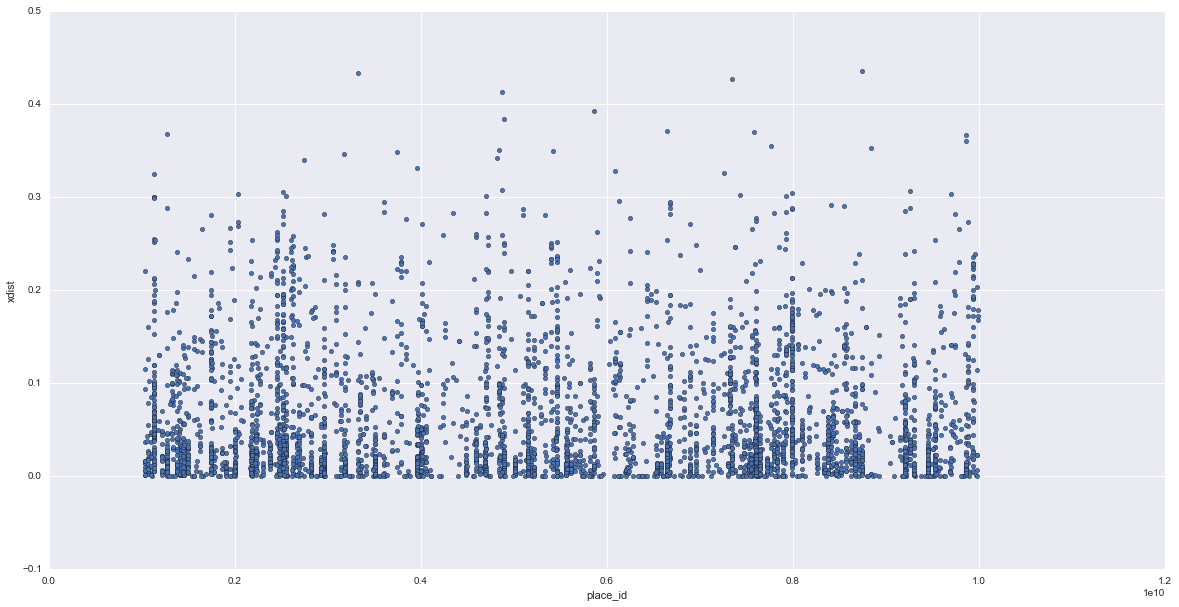

In [115]:
wrong.plot('place_id', 'xdist', kind='scatter', figsize=(20, 10),)

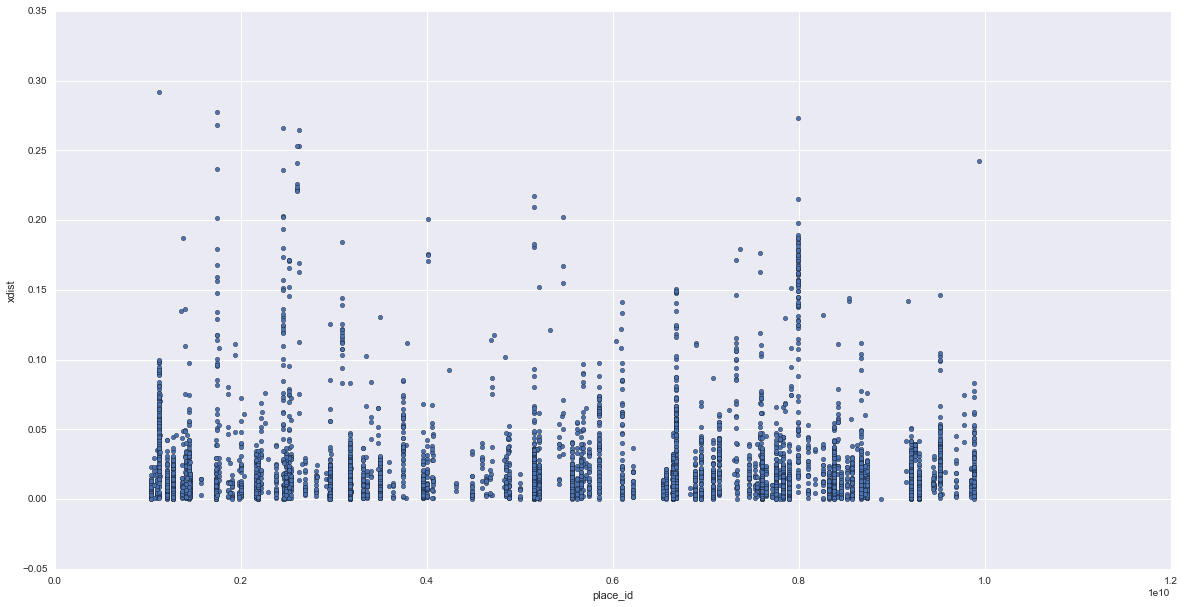

In [116]:
right.plot('place_id', 'xdist', kind='scatter', figsize=(20, 10),)